# Miniproject: Image Classification

### Description

One of the oldest traditions in deep learning is to first tackle the fun problem of MNIST classification. [The MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://keras.io/examples/) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "Adam", "convolutional neural network", "training and validation data", "overfitting", "regularization", and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data (i.e. training).
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length.

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Yixin Cheng"
student2 = "Tiannan Sha"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [1]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.datasets import mnist, fashion_mnist

### Plotting

In [2]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "train")
    ax1.plot(history.history['val_loss'], label = "val")
    ax2.plot(history.history['accuracy'], label = "train")
    ax2.plot(history.history['val_accuracy'], label = "val")
    finalize_standardplot(fig, ax1, ax2)

## Exercise 1: Data import and visualization (6 points)

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. 
The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the training converges faster. This is an advantage in situations like here (or generally when prototyping), where we want to try many different things without having to wait too long. 

1. As a warm-up exercise, use the importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the function `plot_some_samples` defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (2 pts)
3. To prepare for training: 1. transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (you can use `utils.to_categorical` function from keras), and 2. reshape (flatten) the input images to input vectors and rescale the input data into the range [0,1]. (2 pts)

*Hint*: Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets. 

### Solution

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

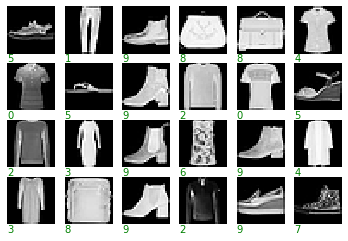

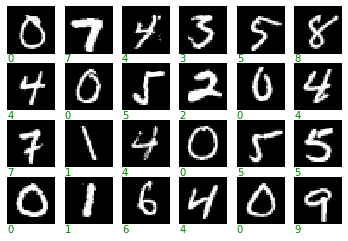

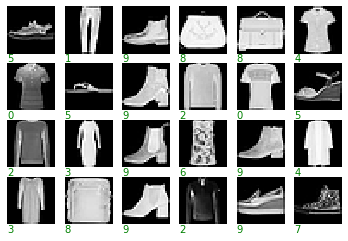

In [5]:
plot_some_samples(x_test, y_test);
plot_some_samples(x_fashion_train, y_fashion_train)

**Answer to Question 2** (1 sentence): 

They are the labels assigned to different kind of images.

**Question 3** 

In [6]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [7]:

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). Note that in this miniproject there is no real test dataset and what is loaded as a test dataset is used for validation. First, implement 1.-3. for the MNIST dataset.  

1. Implement the model with the following specifications: use the softmax activation for the output layer, use the categorical_crossentropy loss, choose stochastic gradient descent for the optimizer, and add the accuracy metric to the metrics. (5 pts)
2. Train for as many epochs as needed to see no further decrease in the validation loss. (1 pt)
3. Plot the learning curves resulting from the fitting procedure (a history object) using the function `plot_history` defined above. (1 pt)
4. Repeat the above steps for fitting the network to the Fashion-MNIST dataset. (2 pts)
5. Report the best validation accuracy achieved for each one of the datasets. Do you observe overfitting already for this simple model? Answer separetely for the MNIST dataset and Fashion-MNIST dataset. (1 pt) 

*Hint:* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).

### Solution

In [8]:
##### for minst ######
model = Sequential() 
model.add(Dense(y_train.shape[1], input_shape=(x_train.shape[1],), activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=SGD(),metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=300, validation_data=(x_test, y_test), verbose=0)

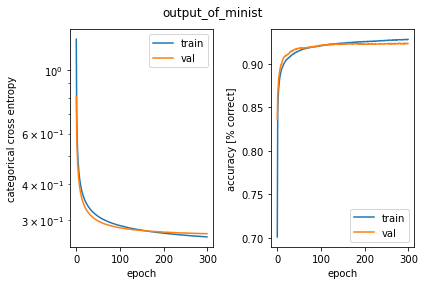

In [9]:
plot_history(history,'output_of_minist')

Test Set error is 7.69%


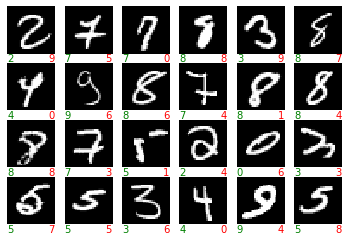

In [10]:
y_predict_test = model.predict(x_test)
error_mnist= np.where(np.argmax(y_test, axis=1) != np.argmax(y_predict_test, axis=1))[0]
plot_some_samples(x_test, y_test, y_predict_test, error_mnist)
print('Test Set error is {:.2f}%'.format((len(error_mnist) / y_test.shape[0]) * 100))

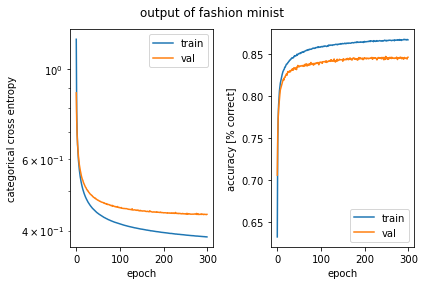

In [11]:
##### for fashion minst ######
model = Sequential() 
model.add(Dense(y_fashion_train.shape[1], input_shape=(x_fashion_train.shape[1],), activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=SGD(),metrics=['accuracy'])
history = model.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=300, validation_data=(x_fashion_test, y_fashion_test), verbose=0)
plot_history(history,'output of fashion minist')

Test Set error is 15.35%


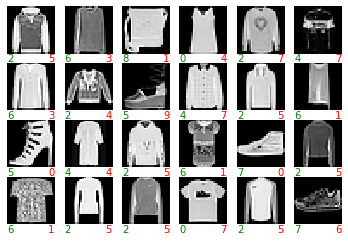

In [12]:
y_fashion_predict_test = model.predict(x_fashion_test)
error_fashion_mnist= np.where(np.argmax(y_fashion_test, axis=1) != np.argmax(y_fashion_predict_test, axis=1))[0]
plot_some_samples(x_fashion_test, y_fashion_test, y_fashion_predict_test, error_fashion_mnist)
print('Test Set error is {:.2f}%'.format((len(error_fashion_mnist) / y_test.shape[0]) * 100))

**Answer to Question 5** (max 2 sentences): 

For MNIST:
The best test error rate is 7.69%. It's already overfitting since the training set accuracy is higher than test set accuracy.

For Fashion mnist:The best test set error is 15.35%. It's already overfitting since the training set accuracy is higher than test set accuracy.

## Exercise 3: One hidden layer, different optimizers (10 points)

Train a network with one hidden layer and compare different optimizers for the MNIST dataset.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/api/models/model/#summary-method) to display your model in a compact way. (1 pt)
2. Train the model for at least 50 epochs with different learning rates of stochastic gradient descent (SGD). What happens if the learning rate $\eta$ is very large (for ex. $\eta=1$), and very small (for ex. $\eta=0.001$)? Comment on the fluctuations of the learning curve. (2 pts)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam) (you can use the default learning rate). (1pt)
4. Plot the learning curves of SGD with a good learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (1 pts)
5. Explain the qualitative difference between the loss and accuracy curves with respect to signs of overfitting. Report the best validation accuracy achieved for SGD and Adam. Which one is better and why do you think so? (2 pts)
6. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples`. (1 pt)

Real-world datasets are labeled by some people and sometimes there are mistakes in the labeling. We will corrupt labels of the MNIST dataset artifically, and observe an overfitting to this noisy dataset with Adam. 

7. Take $ p = 0.2 $ fraction of the data points from the training dataset of MNIST and change their class labels randomly. (You can sample a random integer from 0 to 9 using `np.random.uniform` and `np.floor`). Train with Adam for 50 or 100 epochs. Plot the learning curves. Do you observe overfitting in the validation accuracy? Does it take longer to converge to perfect training accuracy compare to noise-free MNIST? (2 pts)

**Answer to Question 2** (max 2 sentences): 

**Answer to Question 5** (max 3 sentences): 

**Answer to Question 7** (max 2 sentences): 

### Solution

In [13]:
def prepare_standardplot2(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

In [14]:
def build_model(hidden_size=128):
    model=Sequential()
    model.add(Dense(hidden_size, input_shape=(x_train.shape[1],), activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

In [15]:
def train(model,optimizer='SGD',batch_size=32,epochs=300,verbose=0,dataset='mnist'):
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    if dataset == 'mnist':
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_test, y_test),verbose=verbose) 
    elif dataset =='fashion':
        history = model.fit(x_fashion_train, y_fashion_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(x_fashion_test, y_fashion_test),
                            verbose=verbose)
    return history

In [16]:
def get_history(lr_list,optim,epochs):
    history=list()
    for lr in lr_list:
        model = build_model(128)
        optim = keras.optimizers.SGD(lr=lr)
        history.append(train(model, optimizer=optim, epochs=epochs))
    return history

**Question 1** 

In [17]:
model=build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


**Question 2** 

In [18]:
lr_list= [0.0001,0.001,0.005,0.01,0.05,0.1,1]

In [19]:
history_sgd=get_history(lr_list,'SGD',50)

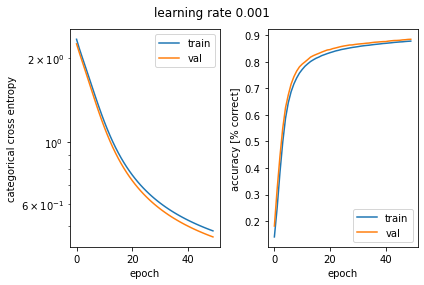

In [20]:
plot_history(history_sgd[0],'learning rate 0.001')

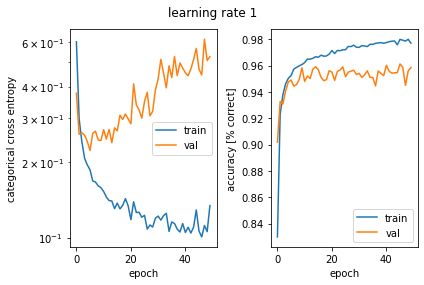

In [21]:
plot_history(history_sgd[6],'learning rate 1')

IF the learning rate is too small,convergence is very slow(accuracy rate rises very slowly),The model is easy to fall into the local optimum.

IF the learning rate is too big will cause the network to fail to converge, hovering around the optimal value.

**Question 3** 

In [22]:
history_adam=get_history(lr_list,'Adam',50)

**Question 4** 

In [23]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot2(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' train')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' val')
    ax1.plot(history_adam.history['loss'], label=label2 + ' train')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' val')
    ax2.plot(history_sgd.history['accuracy'], label=label1 + ' train')
    ax2.plot(history_sgd.history['val_accuracy'], label=label1 + ' val')
    ax2.plot(history_adam.history['accuracy'], label=label2 + ' train')
    ax2.plot(history_adam.history['val_accuracy'], label=label2 + ' val')
    finalize_standardplot(fig, ax1, ax2)
    return fig

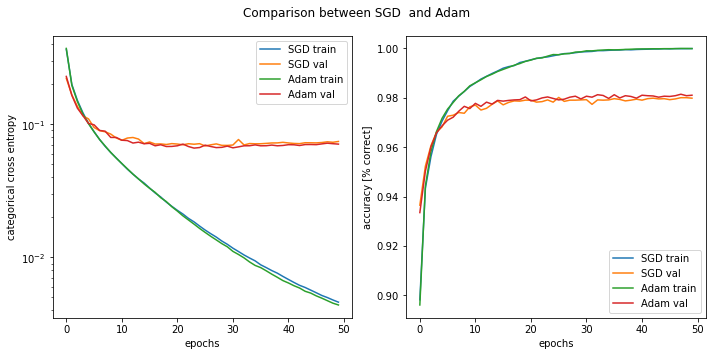

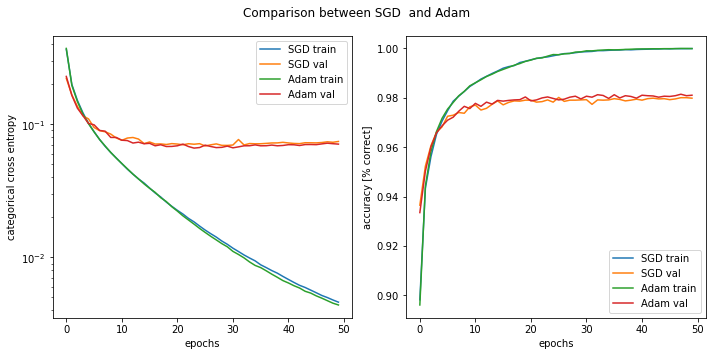

In [24]:
#choose learning rate 0.05 here
comparison_plot(history_sgd[4],history_adam[4],'SGD','Adam','Comparison between SGD  and Adam')

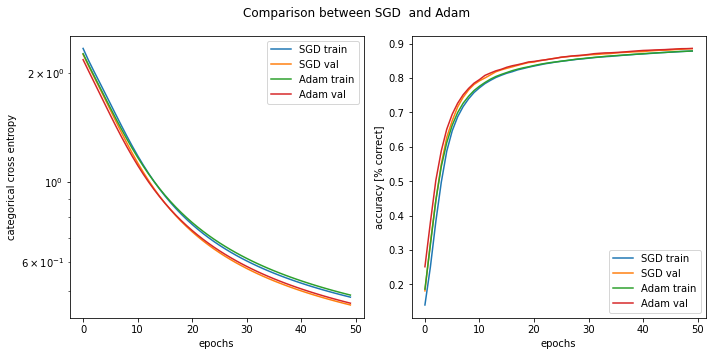

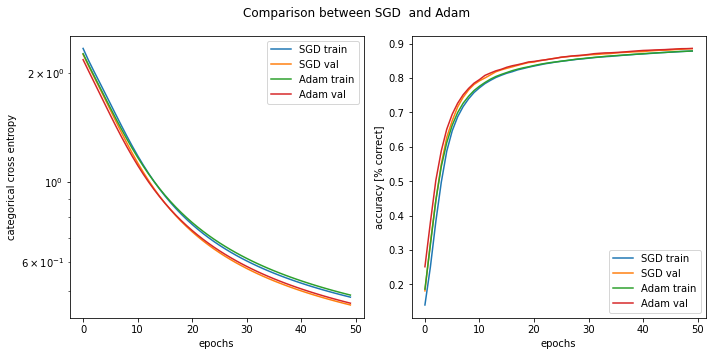

In [25]:
#choose learning rate 0.0001 here
comparison_plot(history_sgd[0],history_adam[0],'SGD','Adam','Comparison between SGD  and Adam')

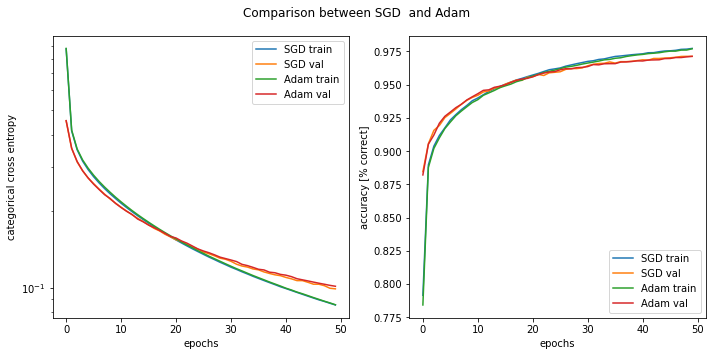

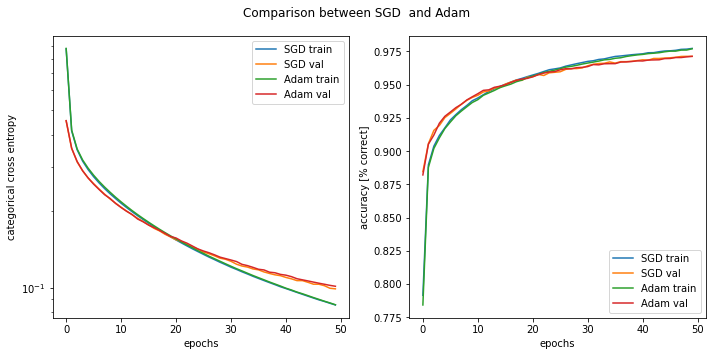

In [26]:
#choose learning rate 0.1 here
comparison_plot(history_sgd[2],history_adam[2],'SGD','Adam','Comparison between SGD  and Adam')

**Question 5** 

In [27]:
#choose learning rate 0.1
max(history_sgd[4].history['val_accuracy'])

0.9800999760627747

Best validation accuracy for SGD is 0.9800.

In [28]:
max(history_adam[4].history['val_accuracy'])

0.9814000129699707

Best validation accuracy for Adam is 0.9814.

We can see from the image above that the training loss keeps decreasing, while after many epochs the validation loss starts to increase,This means that it is starting to be overfitting, which result from our model  fits the noise of the training data.
Most of the time, Adam performs better because of its adaptive learning rate while sometimes Adam may miss the global optimal solution[1] or may not converge[2],we need to depends on our data and using scenario.

[1]Wilson A C , Roelofs R , Stern M , et al. The Marginal Value of Adaptive Gradient Methods in Machine Learning[J]. 2017.

[2]Reddi, S. J. , S. Kale , and S. Kumar . "On the Convergence of Adam and Beyond." (2019).

**Question 6** 

In [29]:
import numpy as np

In [30]:
model=build_model()
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=100,
                            validation_data=(x_test, y_test),verbose=0) 
pred = model.predict_classes(x_test)
y_test_decode=np.argmax(y_test,axis=1)
indices = [i for i,v in enumerate(pred) if pred[i]!=y_test_decode[i]]

C:\Users\Allen\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [31]:
x_wrong=x_test[indices]
y_wrong=y_test[indices]

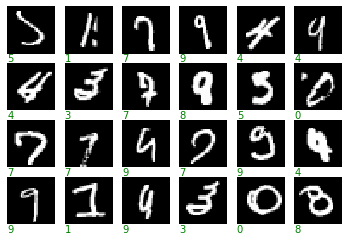

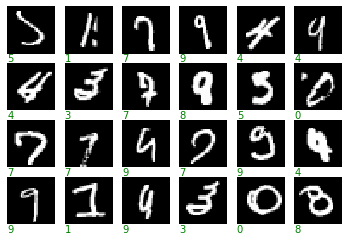

In [32]:
plot_some_samples(x_wrong,y_wrong)

**Question 7** 

In [33]:
import  random
from keras.utils import to_categorical

In [34]:
(noise_x_train, noise_y_train), (noise_x_test, noise_y_test) = mnist.load_data()

In [35]:
index=[i for i in range(0,60000)]

In [36]:
x_changed_index=random.sample(range(0,60000),12000)

In [37]:
for i in x_changed_index:
    noise_y_train[i]=np.random.randint(0,10,1)

In [38]:
noise_y_train = keras.utils.to_categorical(noise_y_train)
noise_x_train = noise_x_train.reshape(x_train.shape[0], noise_x_train.shape[1]*noise_x_train.shape[2])/np.max(noise_x_train)

In [39]:
model=build_model()
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(noise_x_train, noise_y_train, batch_size=32, epochs=50,
                            validation_data=(x_test, y_test),verbose=0) 

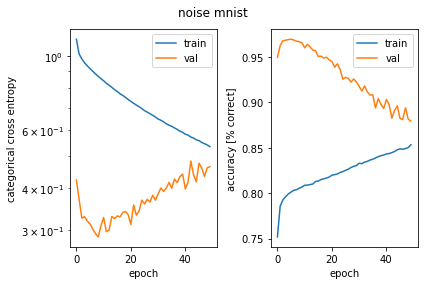

In [40]:
plot_history(history,'noise mnist')

In [41]:
history = model.fit(x_train,y_train, batch_size=32, epochs=50,
                            validation_data=(x_test, y_test),verbose=0) 

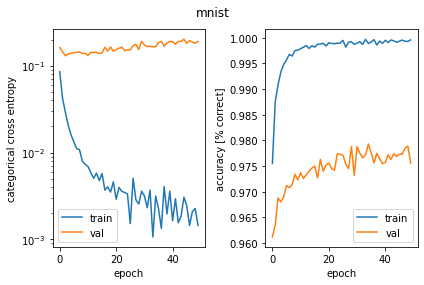

In [42]:
plot_history(history,'mnist')

Yes, we can see from the image that the train accuracy goes higher while the test accuracy gose lower since our model fits the noise of the training data.It doesn't take longer to converge to perfect training accuracy compare to noise-free MNIST.

## Exercise 4: Model performance as a function of number of hidden neurons (8 + 2 points)

Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network in Exercise 3, we use the Fashion-MNIST dataset from now on to compare the performances of more complex models. In this exercise, we investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit at least 4 models with different number of hidden neurons (i.e. width) between 10 and 1000 to the Fashion-MNIST dataset. Train with Adam for 50-100 epochs. (2 pts)
2. Plot the best validation loss and accuracy versus the width. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? Do you observe an overfitting due to the complexity of the wider networks with more parameters? Report the best validation accuracy. (2 pts)
3. Choose $ p \geq 0.5 $ fraction of the data points from the training dataset of Fashion-MNIST and change their class labels randomly as in Exercise 3. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
4. BONUS: Add random Gaussian noise on the input pixels with mean 0 and variance between 0.01-0.5 and use the original labels. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
5. Answer to the same questions in 2 for the noisy Fashion-MNIST dataset(s). Comment on the differences between width-performence curves for these two (or three) datasets. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

**Answer to Question 2** (max 2 sentences): 

**Answer to Question 5** (max 3 sentences): 

### Solution

In [3]:
# prepare data
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()
y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)
x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

#### 4.1
Fit at least 4 models with different number of hidden neurons (i.e. width) between 10 and 1000 to the Fashion-MNIST dataset. Train with Adam for 50-100 epochs.

In [7]:
def build_model(hidden_size=128):
    model=Sequential()
    model.add(Dense(hidden_size, input_shape=(x_fashion_train.shape[1],), activation='relu'))
    model.add(Dense(y_fashion_train.shape[1], activation='softmax'))
    return model

def train(model, x_tr, y_tr, x_te, y_te, optimizer='SGD',batch_size=32,epochs=300,verbose=0):
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(x_tr, y_tr, batch_size=batch_size, epochs=epochs,
                        validation_data=(x_te, y_te), verbose=verbose)
    return history
    
def plot_best_losses_accs(histories, nums_hidden, val_only = True):   
    best_val_losses = []
    best_losses = []
    for h in histories:
        best_val_losses.append(min(h.history['val_loss']))
        best_losses.append(min(h.history['loss']))

    best_val_accs = []
    best_accs = []
    for h in histories:
        best_val_accs.append(max(h.history['val_accuracy']))
        best_accs.append(max(h.history['accuracy']))

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,6))

    if val_only==False:
        ax1.plot(nums_hidden, best_losses, marker=".", color = 'orange', label="train loss")
    ax1.plot(nums_hidden, best_val_losses, marker=".", color='blue', label = "val loss")
    ax1.set_xlabel('Hidden size')
    ax1.set_ylabel('Minimum losses')
    ax1.legend()
        
    if val_only==False:
        ax2.plot(nums_hidden, best_accs, marker=".", color='orange', label="train acc")
    ax2.plot(nums_hidden, best_val_accs, marker=".", color='blue', label="val acc")
    ax2.set_xlabel('Hidden size')
    ax2.set_ylabel('Maximum accuracy')
    ax2.legend()

    best_of_all_acc = max(best_val_accs)
    print(f"best validation accuracy of all models = {best_of_all_acc}")

In [8]:
# num of neurons in  hidden layers
nums_hidden = [10, 50, 100, 300, 900]
histories = []
for n_h in nums_hidden:
    model = build_model(n_h)
    opt = keras.optimizers.Adam(lr=0.001, decay=1e-6) # todo mayebe tune lr a bit
    histories.append(train(model, optimizer=opt, epochs=50, 
                           x_tr=x_fashion_train, y_tr=y_fashion_train, 
                           x_te=x_fashion_test, y_te=y_fashion_test))  #todo change epochs to larger

#### 4.2

best validation accuracy of all models = 0.8984000086784363


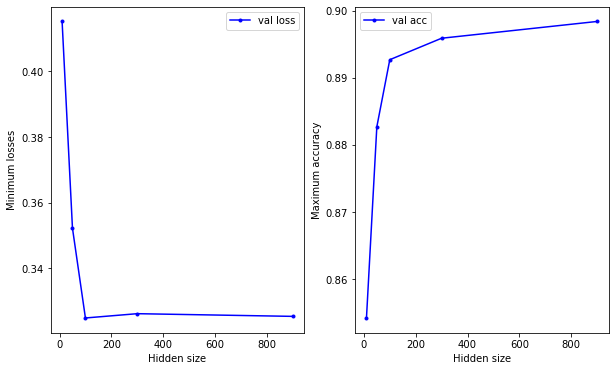

In [373]:
nums_hidden = [10, 50, 100, 300, 900] #todo delete this
plot_best_print("compare training and validation loss and accuracy")
losses_accs(histories, nums_hidden)

compare training and validation loss and accuracy
best validation accuracy of all models = 0.8984000086784363


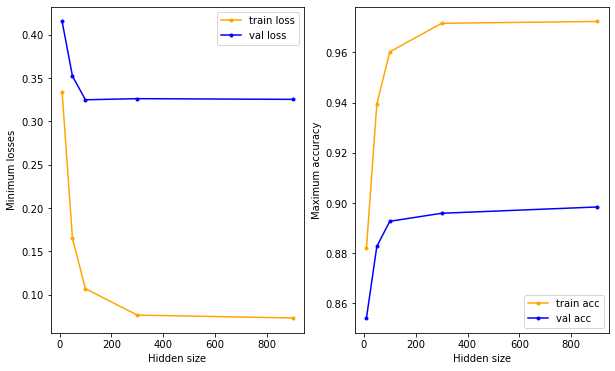

In [374]:
print("compare training and validation loss and accuracy")
plot_best_losses_accs(histories, nums_hidden, val_only=False)

*Question 4.2*: Is the observed trend in accordance with the general approximation theorem? Do you observe an overfitting due to the complexity of the wider networks with more parameters? Report the best validation accuracy.<br>
*Answer*: <br>
- Yes, the trend is in general in accordance with the general approximation theorem because the validation accuracy continues to increase to greater 0.9 and the training accuracy continues to grow to >96% as the number of hidden units increases. 
- I do not observe overfitting due to the complexity of the wider networks because as the width grows, both the validation loss and training loss have similar trend of first decrease then stay stable and both the validation accuracy and training accuracy have similar trend of first grow then stay stable.

- best validation accuracy = 0.8984000086784363

#### 4.3
Choose $ p = 0.5 $ fraction of the data points from the training dataset of Fashion-MNIST and change their class labels randomly as in Exercise 3.

In [12]:
# alter half of the training labels
from random import sample

y_fashion_altered = np.copy(y_fashion_train)
indices_to_change = sample(range(0,y_fashion_train.shape[0]), int(y_fashion_train.shape[0]*0.5))
for i in indices_to_change:
    y_fashion_altered[i] = np.random.randint(0, 10 ,1)

In [350]:
#  fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs.
nums_hidden = [10, 30, 90, 250]
histories_wrong_label = []
for n_h in nums_hidden:
    model = build_model(n_h)
    opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6) # todo mayebe tune lr a bit
    histories_wrong_label.append(train(model, optimizer=opt, epochs=50, 
                                x_tr=x_fashion_train, y_tr=y_fashion_altered, 
                                x_te=x_fashion_test, y_te=y_fashion_test))  #todo change epochs to 150

best validation accuracy of all models = 0.23729999363422394


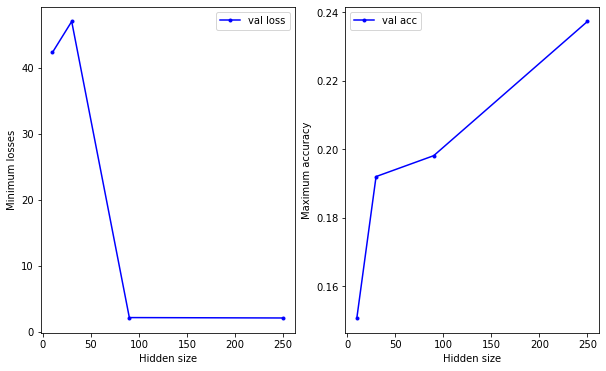

In [375]:
# Plot the best validation loss and accuracy vs. width
nums_hidden = [10, 30c, 90, 250]
plot_best_losses_accs(histories_wrong_label, nums_hidden)

best validation accuracy of all models = 0.23729999363422394


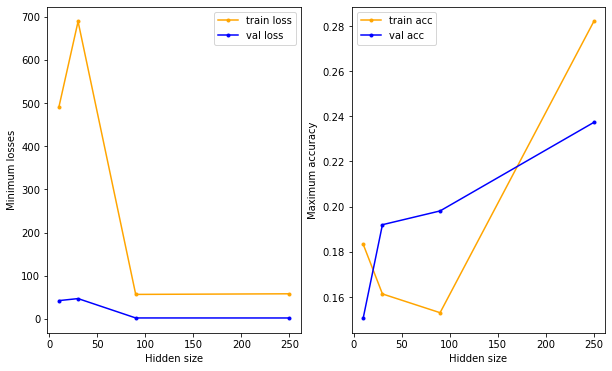

In [377]:
plot_best_losses_accs(histories_wrong_label, nums_hidden, val_only = False)

#### 4.4

Add random Gaussian noise on the input pixels with mean 0 and variance 0.2 and use the original labels

In [352]:
#Add random Gaussian noise on the input pixels with mean 0 and variance between 0.01-0.5 and use the original labels.
from keras.layers import GaussianNoise
import tensorflow.keras.backend as K

layer = GaussianNoise(0.2)
x_f_train_Gau = layer(K.constant(x_fashion_train), training = True).numpy()

# verify that small Gaussian noises have been added
print(x_fashion_train)
print(x_f_train_Gau)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[-0.04723353 -0.21685162 -0.02213614 ... -0.1926661   0.31512576
  -0.24554013]
 [-0.10502209 -0.00683602 -0.08576871 ...  0.13719955 -0.07285885
  -0.06917734]
 [-0.05947852 -0.13041    -0.35752118 ...  0.00851304 -0.18923351
  -0.00454413]
 ...
 [ 0.0063409   0.03744894  0.28656304 ... -0.21706545  0.07355817
  -0.09776231]
 [ 0.47390008 -0.00369979 -0.00200391 ... -0.06313279 -0.22212994
   0.2089012 ]
 [ 0.02541904 -0.45860678 -0.09480961 ...  0.43830577 -0.1128987
  -0.04568327]]


In [355]:
# fit at least 4 models with different widths between 10 and 250. 
# Train with Adam for at least 150 epochs. 
#  fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs.
nums_hidden = [10, 30, 90, 250]
histories_Gau_noise = []
for n_h in nums_hidden:
    model = build_model(n_h)
    opt = keras.optimizers.Adam(lr=0.001, decay=1e-6) # todo mayebe tune lr a bit
    histories_Gau_noise.append(train(model, optimizer=opt, epochs=150, 
                                x_tr=x_f_train_Gau, y_tr=y_fashion_train, 
                                x_te=x_fashion_test, y_te=y_fashion_test))  #todo change epochs to 150

best validation accuracy of all models = 0.882099986076355


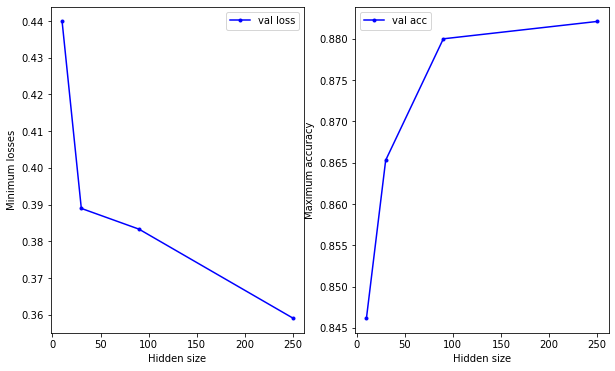

In [378]:
nums_hidden = [10, 30, 90, 250]
plot_best_losses_accs(histories_Gau_noise, nums_hidden)

best validation accuracy of all models = 0.882099986076355


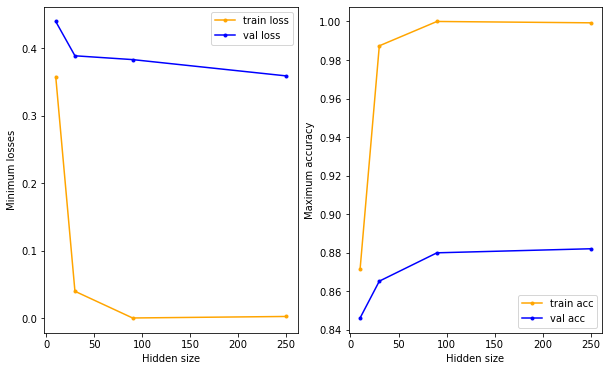

In [379]:
plot_best_losses_accs(histories_Gau_noise, nums_hidden, val_only = False)

#### 4.5 
Answer to the same questions in 2 for the noisy Fashion-MNIST dataset(s). Comment on the differences between width-performence curves for these two (or three) datasets.<br>

- For noisy fashion Mnist datasets,  the observed trend is in general in accordance with the general approximation theorem as the train and validation accuracy in general increases as the number of hidden units increases and the train and validation loss in general decreases as the number of hidden units increases. 
- I don't observe an overfitting for noisy datasets because as the number of hidden units increases, the validation accuracy continues to increase and the validation loss continues to drop.
- The main difference between width-performence curves the noisy and non-noisy Mnist is that for non-noisy Mnist, when training loss is still declining as width increases the validation loss stopped decreasing, but for noisy Mnist the validation loss keeps going down as long as training loss goes down.

## Exercise 5: Going deeper: tricks and regularization (10 + 2 points)

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. We use Fashion-MNIST dataset in this exercise.  

1. Choose a width $ h $ between 50-200 and use at least two hidden layers with $ h $ hidden neurons (each) and train the network for at least 150 epochs. (2 pts)
2. Plot the learning curves and report the best validation accuracy. Do you observe overfitting? (2 pts)
3. Keep the network at the same size. Use a very large l2 regularization $\lambda$ (for ex. $\lambda=1$) and a small one (for ex. $\lambda=0.001$) on kernel weights and report the validation accuracies. What do you observe?  (2 pts)
4. Turn off the $ \ell_2 $ regularization and use a large dropout rate (for ex. 0.5) and a small one (for ex. 0.05) at all hidden layers and report the validation accuracies. What do you observe? (2 pts)
5. BONUS: Try built-in data augmentation methods as a way to regularize: this may include horizontal flipping of the images or small rotations. You can use built-in methods in Keras. Report the augmentation method you used and the best validation accuracy. (2 pts)

Note that one needs to cross-validate to find the right regularization parameter for the model you chose and for the dataset at hand. However we do not enforce this hyperparameter search as it takes long computation times but it is a good practice if you try it here. 

6. Compare the validation accuracies resulting from your attempts to reduce overfitting. Did you improve the validation accuracy? If not, comment on the possible sources of failure. (2 pts)

**Answer to Question 2** (max 1 sentence):   

**Answer to Question 3** (max 2 sentences): 

**Answer to Question 4** (max 2 sentences): 

**Answer to Question 5 (BONUS)** (max 2 sentences): 

**Answer to Question 6** (max 2 sentences): 

### Solution

In [18]:
import tensorflow as tf
def two_hidden_layer_model(hidden_size=50, lambda_=0, dropout_rate=0):
    model=Sequential()
    model.add(Dense(hidden_size, input_shape=(x_fashion_train.shape[1],), activation='relu',
                   kernel_regularizer=tf.keras.regularizers.l2(lambda_))
             )
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_fashion_train.shape[1], activation='softmax'))
    return model

def learning_curve_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

def learning_curve_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


#### 5.1 
Choose a width  ℎ  between 50-200 and use at least two hidden layers with  ℎ  hidden neurons (each) and train the network for at least 150 epochs.

In [19]:
model = two_hidden_layer_model(50)
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6) # todo mayebe tune lr a bit
history_2hl = train(model, optimizer=opt, epochs=150, 
                      x_tr=x_fashion_train, y_tr=y_fashion_train, 
                      x_te=x_fashion_test, y_te=y_fashion_test)  #todo change epochs to larger

#### 5.2 
Plot the learning curves and report the best validation accuracy. Do you observe overfitting?

best validation accuracy = 0.8889999985694885


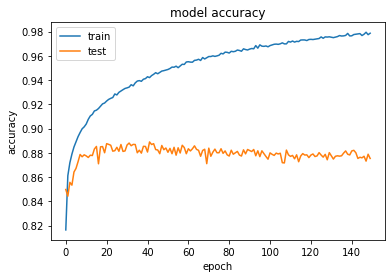

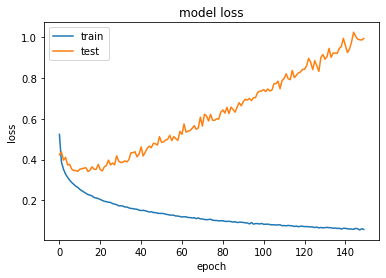

In [20]:
print(f"best validation accuracy = {max(history_2hl.history['val_accuracy'])}")
learning_curve_accuracy(history_2hl)
learning_curve_loss(history_2hl)

answer to 5.2 <br>
- Yes I observe overfitting because although the training accuracy and training loss keep improving, the validation accuracy and loss stopped improving and even became worse after about 20 epoch

3. Keep the network at the same size. Use a very large l2 regularization $\lambda$ (for ex. $\lambda=1$) and a small one (for ex. $\lambda=0.001$) on kernel weights and report the validation accuracies. What do you observe? 

In [21]:
# model with big l2 regularization
big_l2_reg_model = two_hidden_layer_model(hidden_size=50, lambda_=1)
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6) # todo mayebe tune lr a bit
history_l2_b = train(big_l2_reg_model, optimizer=opt, epochs=150, 
                x_tr=x_fashion_train, y_tr=y_fashion_train, 
                x_te=x_fashion_test, y_te=y_fashion_test)  #todo change epochs to larger

model with big regularization best validation accuracy = 0.8047000169754028


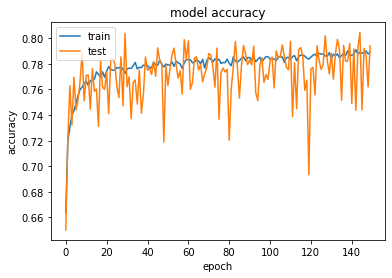

In [22]:
print(f"model with big regularization best validation accuracy = {max(history_l2_b.history['val_accuracy'])}")
learning_curve_accuracy(history_l2_b)

In [23]:
# small l2 regularization
small_l2_reg_model = two_hidden_layer_model(hidden_size=50, lambda_=0.001)
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6) # todo mayebe tune lr a bit
history_l2_s = train(small_l2_reg_model, optimizer=opt, epochs=150, 
                x_tr=x_fashion_train, y_tr=y_fashion_train, 
                x_te=x_fashion_test, y_te=y_fashion_test)  #todo change epochs to larger

model with small regularization best accuracy = 0.8830000162124634


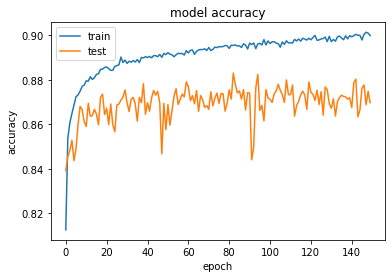

In [24]:
print(f"model with small regularization best accuracy = {max(history_l2_s.history['val_accuracy'])}")
learning_curve_accuracy(history_l2_s)

Answer to 5.3:
- NN with small regularization has better train accuracy and better validation accuracy than NN with big regularization
- NN with small regularization's validation accuracy is more stable (less variance) than NN with big regularization's validation accuracy.

5.4. Turn off the $ \ell_2 $ regularization and use a large dropout rate (for ex. 0.5) and a small one (for ex. 0.05) at all hidden layers and report the validation accuracies. What do you observe? (2 pts)

In [25]:
# model with big dropout rate
model = two_hidden_layer_model(hidden_size=50, dropout_rate=0.5)
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6) # todo mayebe tune lr a bit
history_dr_b = train(model, optimizer=opt, epochs=150, 
                x_tr=x_fashion_train, y_tr=y_fashion_train, 
                x_te=x_fashion_test, y_te=y_fashion_test)

model with big dropout rate best valiadation accuracy = 0.8582000136375427


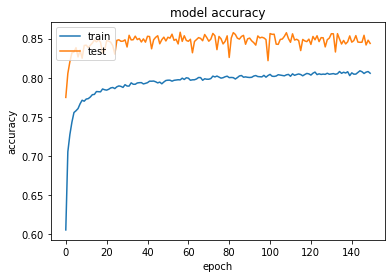

In [26]:

# todo rerun this plots and some plots before this because the y axis label was wrong
print(f"model with big dropout rate best valiadation accuracy = {max(history_dr_b.history['val_accuracy'])}")
learning_curve_accuracy(history_dr_b)

In [27]:
model = two_hidden_layer_model(hidden_size=50, dropout_rate=0.05)
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6) # todo mayebe tune lr a bit
history_dr_s = train(model, optimizer=opt, epochs=150, 
                x_tr=x_fashion_train, y_tr=y_fashion_train, 
                x_te=x_fashion_test, y_te=y_fashion_test)

model with small dropout rate best validation accuracy = 0.8902000188827515


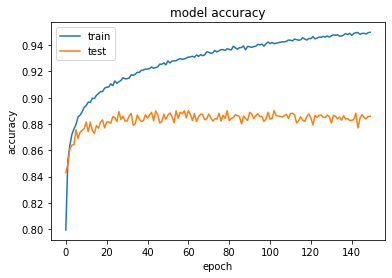

In [28]:
print(f"model with small dropout rate best validation accuracy = {max(history_dr_s.history['val_accuracy'])}")
learning_curve_accuracy(history_dr_s)

Answer to 5.4: 
- large dropout rate has strong regularization effect -- the validation accuracy is even better than the training accuracy
- but overall the small dropout rate yields better accuracy for this particular setting.

5.5 Try built-in data augmentation methods as a way to regularize: this may include horizontal flipping of the images or small rotations. You can use built-in methods in Keras. Report the augmentation method you used and the best validation accuracy.

In [29]:
from keras.preprocessing.image import ImageDataGenerator
#reshape because datagen needs rank 4 input matrix(Image Index, height, widht, depth)
x_f_train_auged = x_fashion_train.reshape(60000, 28, 28, 1)
datagen = ImageDataGenerator(rotation_range=10) # or horizontal_flip=True
datagen.fit(x_f_train_auged)
img_iter = datagen.flow(x_f_train_auged, y_fashion_train, batch_size=60000)  # datagen.flow return an iterator that outputs batches of data
x_f_train_auged, y_fashion_train_auged = img_iter.next() 
x_f_train_auged = x_f_train_auged.reshape(-1, 28*28)


augmented dataset


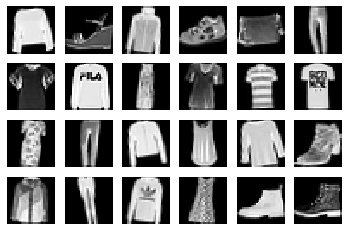

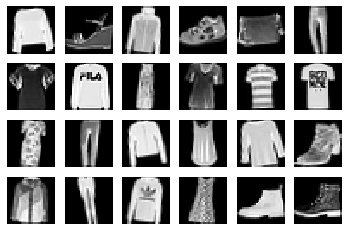

In [30]:
print("augmented dataset")
plot_some_samples(x_f_train_auged)

In [432]:
# train model on augmented dataset
model = two_hidden_layer_model(hidden_size=50)
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)
history_auged = train(model, optimizer=opt, epochs=150, 
                x_tr=x_f_train_auged, y_tr=y_fashion_train_auged, 
                x_te=x_fashion_test, y_te=y_fashion_test)

model with big regularization best accuracy = 0.8733000159263611


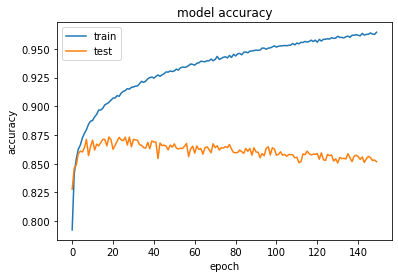

In [434]:
print(f"model with big regularization best accuracy = {max(history_auged.history['val_accuracy'])}")
learning_curve_accuracy(history_auged)

Answer to 5.5
- The augmentation method I used was random rotations with rotation_range=10.
- Best validation accuracy = 0.8733000159263611

5.6 Compare the validation accuracies resulting from your attempts to reduce overfitting. Did you improve the validation accuracy? If not, comment on the possible sources of failure.<br>
Answer to 5.6
- yes, dropout with small dropout rate improved the validation accuracy and reduced overfitting
- l2 regularization didn't work well maybe because the lambdas we were asked to choose were either too big (0.1) or too small (0.001)

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

Convolutional neural networks have an inductive bias that is well adapted to image classification. 

1. Design a convolutional neural network and train it without using explicit regularizers. (2 pts)
2. Try to improve the best validation scores of the model by experiment with batch_normalization layers, dropout layers and l2-regularization on weights (kernels) and biases. (4 pts)
3. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized) together in a comparison plot. (2pts)
4. How does the CNN performance compare to the so far best performing (deep) neural network model? (2 pts)

*Hint:* You may get valuable inspiration from the keras [examples](https://keras.io/examples/), [for example](https://keras.io/examples/vision/mnist_convnet/).

**Answer to Question 4**: 

### Solution

In [31]:
from tensorflow.keras import layers

In [32]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### 6.1 Vanilla CNN

In [33]:
# build model
cnn_naive = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),   # 5,5,64
        layers.Flatten(),  #1600
        #layers.Dense(128, activation = "relu"),  
        layers.Dense(num_classes, activation="softmax"),
    ]
)

#model.summary()

In [34]:
def train(model, epochs=50):
    batch_size = 128
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
    
    return history

In [437]:
history_naive = train(cnn_naive)
#todo  split train to get an validation or just use test set as validation ? I think it's okay to use test set, because 
# otherwise we are won't be using testset 

Epoch 1/50
469/469 [==============================] - 34s 71ms/step - loss: 0.8879 - accuracy: 0.7010 - val_loss: 0.4580 - val_accuracy: 0.8408
Epoch 2/50
469/469 [==============================] - 32s 68ms/step - loss: 0.4056 - accuracy: 0.8570 - val_loss: 0.3873 - val_accuracy: 0.8622
Epoch 3/50
469/469 [==============================] - 32s 69ms/step - loss: 0.3525 - accuracy: 0.8740 - val_loss: 0.3548 - val_accuracy: 0.8724
Epoch 4/50
469/469 [==============================] - 32s 68ms/step - loss: 0.3194 - accuracy: 0.8858 - val_loss: 0.3435 - val_accuracy: 0.8753
Epoch 5/50
469/469 [==============================] - 32s 68ms/step - loss: 0.2982 - accuracy: 0.8922 - val_loss: 0.3270 - val_accuracy: 0.8834
Epoch 6/50
469/469 [==============================] - 32s 69ms/step - loss: 0.2790 - accuracy: 0.8981 - val_loss: 0.3112 - val_accuracy: 0.8875
Epoch 7/50
469/469 [==============================] - 32s 68ms/step - loss: 0.2692 - accuracy: 0.9019 - val_loss: 0.3067 - val_accuracy:

In [438]:
best_val_acc_naive = max(history_naive.history["val_accuracy"])
print(f"best validation accuracy = {best_val_acc_naive}")

best validation accuracy = 0.9107000231742859


#### 6.2 atempt (1), add dropout


In [36]:
# try dropout, 
# build model
cnn_dropout = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),   # 5,5,64
        layers.Flatten(),  #1600
        layers.Dropout(0.5), 
        layers.Dense(num_classes, activation="softmax"),
    ]
)

#model.summary()

In [457]:
history_dropout = train(cnn_dropout)

Epoch 1/50
469/469 [==============================] - 33s 69ms/step - loss: 0.9891 - accuracy: 0.6456 - val_loss: 0.4518 - val_accuracy: 0.8360
Epoch 2/50
469/469 [==============================] - 32s 69ms/step - loss: 0.4566 - accuracy: 0.8348 - val_loss: 0.3978 - val_accuracy: 0.8637
Epoch 3/50
469/469 [==============================] - 33s 70ms/step - loss: 0.3977 - accuracy: 0.8574 - val_loss: 0.3624 - val_accuracy: 0.8713
Epoch 4/50
469/469 [==============================] - 33s 69ms/step - loss: 0.3668 - accuracy: 0.8679 - val_loss: 0.3379 - val_accuracy: 0.8804
Epoch 5/50
469/469 [==============================] - 33s 69ms/step - loss: 0.3435 - accuracy: 0.8757 - val_loss: 0.3232 - val_accuracy: 0.8856
Epoch 6/50
469/469 [==============================] - 33s 70ms/step - loss: 0.3247 - accuracy: 0.8831 - val_loss: 0.3121 - val_accuracy: 0.8895
Epoch 7/50
469/469 [==============================] - 33s 70ms/step - loss: 0.3141 - accuracy: 0.8866 - val_loss: 0.3003 - val_accuracy:

In [458]:
best_val_acc_dropout = max(history_dropout.history["val_accuracy"])
print(f"best validation accuracy = {best_val_acc_dropout}")

best validation accuracy = 0.9154999852180481


#### attempt(2), add batchnorm

In [38]:
# try batchnorm
# build model
cnn_bn = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),   # 5,5,64
        layers.Flatten(),  #1600
        layers.BatchNormalization(),
        #layers.Dense(128, activation = "relu"),  
        layers.Dense(num_classes, activation="softmax"),
    ]
)

#model.summary()  # only use bn after flatten gives 0.8831 for 2 epochs of training

In [448]:
history_bn = train(cnn_bn)

Epoch 1/50
469/469 [==============================] - 72s 152ms/step - loss: 0.5613 - accuracy: 0.8036 - val_loss: 0.6250 - val_accuracy: 0.7763
Epoch 2/50
469/469 [==============================] - 71s 151ms/step - loss: 0.2962 - accuracy: 0.8928 - val_loss: 0.3075 - val_accuracy: 0.8898
Epoch 3/50
469/469 [==============================] - 71s 152ms/step - loss: 0.2485 - accuracy: 0.9103 - val_loss: 0.2933 - val_accuracy: 0.8926
Epoch 4/50
469/469 [==============================] - 72s 154ms/step - loss: 0.2225 - accuracy: 0.9185 - val_loss: 0.2922 - val_accuracy: 0.8950
Epoch 5/50
469/469 [==============================] - 71s 152ms/step - loss: 0.2012 - accuracy: 0.9259 - val_loss: 0.3805 - val_accuracy: 0.8689
Epoch 6/50
469/469 [==============================] - 71s 152ms/step - loss: 0.1863 - accuracy: 0.9322 - val_loss: 0.3003 - val_accuracy: 0.8997
Epoch 7/50
469/469 [==============================] - 71s 152ms/step - loss: 0.1791 - accuracy: 0.9351 - val_loss: 0.3783 - val_ac

In [449]:
best_val_acc_bn = max(history_bn.history["val_accuracy"])
print(f"best validation accuracy = {best_val_acc_bn}")

best validation accuracy = 0.907800018787384


#### 6.2 attemp 3, use L2 regularization

In [40]:
lambda_ = 0.01
cnn_bn_l2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(lambda_),
                     bias_regularizer=tf.keras.regularizers.l2(lambda_)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(lambda_), 
                     bias_regularizer=tf.keras.regularizers.l2(lambda_)),
        layers.MaxPooling2D(pool_size=(2, 2)),   # 5,5,64
        layers.Flatten(),  #1600
        layers.BatchNormalization(),
        #layers.Dense(128, activation = "relu"),  
        layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    ]
)

In [451]:
history_l2 = train(cnn_bn_l2)

Epoch 1/50
469/469 [==============================] - 34s 70ms/step - loss: 0.9912 - accuracy: 0.8020 - val_loss: 0.8568 - val_accuracy: 0.8360
Epoch 2/50
469/469 [==============================] - 33s 70ms/step - loss: 0.4882 - accuracy: 0.8794 - val_loss: 0.5706 - val_accuracy: 0.8281
Epoch 3/50
469/469 [==============================] - 33s 70ms/step - loss: 0.4443 - accuracy: 0.8870 - val_loss: 0.4757 - val_accuracy: 0.8738
Epoch 4/50
469/469 [==============================] - 33s 69ms/step - loss: 0.4298 - accuracy: 0.8885 - val_loss: 0.5132 - val_accuracy: 0.8523
Epoch 5/50
469/469 [==============================] - 33s 70ms/step - loss: 0.4201 - accuracy: 0.8905 - val_loss: 0.4485 - val_accuracy: 0.8769
Epoch 6/50
469/469 [==============================] - 33s 70ms/step - loss: 0.4129 - accuracy: 0.8957 - val_loss: 0.4575 - val_accuracy: 0.8768
Epoch 7/50
469/469 [==============================] - 33s 70ms/step - loss: 0.4099 - accuracy: 0.8945 - val_loss: 0.4515 - val_accuracy:

In [452]:
best_val_acc_l2 = max(history_l2.history["val_accuracy"])
print(f"best validation accuracy = {best_val_acc_l2}")

best validation accuracy = 0.8964999914169312


#### 6.2 attempt 4, use both batchnorm and L2 regularization


In [42]:
# todo.. maybe also try combined approach also batch norm can be used before convolutional layer
# maybe just try 4 models see how it goes.. since it's 4 marks
lambda_ = 0.01
cnn_bn_l2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(lambda_),
                     bias_regularizer=tf.keras.regularizers.l2(lambda_)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(lambda_), 
                     bias_regularizer=tf.keras.regularizers.l2(lambda_)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),   # 5,5,64
        layers.Flatten(),  #1600
        layers.BatchNormalization(),
        #layers.Dense(128, activation = "relu"),  
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [454]:
history_bn_l2 = train(cnn_bn_l2)

Epoch 1/50
469/469 [==============================] - 72s 152ms/step - loss: 0.8462 - accuracy: 0.8139 - val_loss: 0.9625 - val_accuracy: 0.7193
Epoch 2/50
469/469 [==============================] - 70s 149ms/step - loss: 0.4036 - accuracy: 0.8924 - val_loss: 0.4430 - val_accuracy: 0.8712
Epoch 3/50
469/469 [==============================] - 70s 150ms/step - loss: 0.3440 - accuracy: 0.9019 - val_loss: 0.4190 - val_accuracy: 0.8678
Epoch 4/50
469/469 [==============================] - 70s 150ms/step - loss: 0.3178 - accuracy: 0.9078 - val_loss: 0.5160 - val_accuracy: 0.8496
Epoch 5/50
469/469 [==============================] - 71s 151ms/step - loss: 0.3078 - accuracy: 0.9077 - val_loss: 0.3893 - val_accuracy: 0.8842
Epoch 6/50
469/469 [==============================] - 70s 150ms/step - loss: 0.3002 - accuracy: 0.9109 - val_loss: 0.4085 - val_accuracy: 0.8824
Epoch 7/50
469/469 [==============================] - 71s 151ms/step - loss: 0.2856 - accuracy: 0.9151 - val_loss: 0.3821 - val_ac

In [455]:
best_val_acc_bn_l2 = max(history_bn_l2.history["val_accuracy"])
print(f"best validation accuracy = {best_val_acc_bn_l2}")

best validation accuracy = 0.9059000015258789


6.3 After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized) together in a comparison plot.

- We chose our tuned model to be the model with a dropout layer added to the fully connected layer. We can clearly see that dropout is preventing overfitting

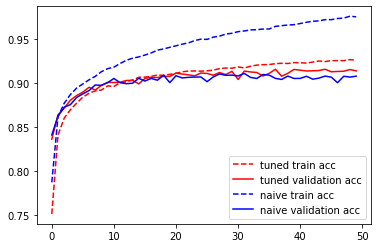

In [460]:
plt.plot(history_dropout.history["accuracy"], label = "tuned train acc", linestyle = "--", color='red')
plt.plot(history_dropout.history["val_accuracy"], label = "tuned validation acc", color= 'red')
plt.plot(history_naive.history["accuracy"], label = "naive train acc", linestyle = "--", color='blue')
plt.plot(history_naive.history["val_accuracy"], label = "naive validation acc", color = 'blue')
plt.legend()

6.4 How does the CNN performance compare to the so far best performing (deep) neural network model?
- CNN performance (for naive cnn, best val acc = 0.911; for tuned cnn, best val acc = 0.915) is better than the so far best performing (deep) neural network model (one hidden layer with 900 node, best val acc = 0.898)